## Improting Required libraries

In [1]:
import mne
import matplotlib.pyplot as plt
import glob
import numpy as np
import asrpy

## Enabling CUDA use for MNE

In [2]:
mne.utils.set_config('MNE_USE_CUDA', 'true')  

## Reading Dataset
We are reading four different kinds of datasets depicting 
- Heartfulness Meditation (htr)
- Concentration Meditation (ctr)
- Vipassana Meditation (vip)
- Sahaja Yoga Meditation (sny)

respectively.

In [3]:
%%capture
# To avoid unneccesary writing

# Files we need
raw_data = []

# Types of data
data_we_need = ['015', '026', '062', '080']

for subject_number in data_we_need:
    for name in glob.glob('../sub-'+subject_number+'/eeg/*.bdf'):
        try:
            data = mne.io.read_raw_bdf(name, preload=True)
            times = data.times
            duration = times[-1] - times[0]
            # Getting onnly data greater than or equal to 10 minutes
            if duration >= 600:
                raw_data.append(data)
        except:
            print(name +" not loaded")

In [4]:
# Getting indexes of all datas
med1 = [1, 4, 9, 13]
med2 = [2, 5, 10, 15]
think1 = [0, 6, 8, 14]
think2 = [3, 7, 11, 12]

## Preprocessing Data
In this process, we will extract the necessary duration of data required and perform data cleaning to remove any artifacts.
- Dropping unnecessary channels
- Cropping data
- Filtering data (notch filter and bandpass filter)
- Applying ICA

In [5]:
# Dropping EXG1, EXG2, ..., EXG8, Status channel
channels_to_drop = ['EXG' + str(i) for i in range(1, 9)]
channels_to_drop.append('Status')
raw_data = [data.drop_channels(channels_to_drop) for data in raw_data]

In [6]:
# Croping Data 
# Considering only first 10 minutes
cropped_raw_data = []

for files in raw_data:
    cropped_raw_data.append(files.crop(tmin=0.0, tmax=600.0))

### Downsampling data

In [7]:
# Downsampling data to 256 Hz
raw_resampled = [raw_data.copy().resample(sfreq=256, npad="auto", n_jobs="cuda") for raw_data in cropped_raw_data]

Now using CUDA device 0
Enabling CUDA with 14.91 GB available memory
Using CUDA for FFT resampling
Using CUDA for FFT resampling
Using CUDA for FFT resampling
Using CUDA for FFT resampling
Using CUDA for FFT resampling
Using CUDA for FFT resampling
Using CUDA for FFT resampling
Using CUDA for FFT resampling
Using CUDA for FFT resampling
Using CUDA for FFT resampling
Using CUDA for FFT resampling
Using CUDA for FFT resampling
Using CUDA for FFT resampling
Using CUDA for FFT resampling
Using CUDA for FFT resampling
Using CUDA for FFT resampling


In [8]:
# Preprocessing
# Cleaning the entire EEG 
def get_filtered_eeg(raw):
    low_freq = 0.3
    high_freq = 100.0

    raw_filtered = raw.copy().notch_filter(freqs=50)

    # Apply the bandpass filter
    raw_filtered = raw_filtered.filter(l_freq=low_freq, h_freq=high_freq, fir_design='firwin', n_jobs="cuda")

    #ASR cleaning with cutoff=20
    # asr = asrpy.ASR(sfreq=raw.info["sfreq"], cutoff=20)
    # asr.fit(raw_filtered)
    # raw_filtered = asr.transform(raw_filtered)

    ica = mne.preprocessing.ICA(n_components=15, max_iter="auto", random_state=97)
    ica.fit(raw_filtered)

    # # ica.plot_components()

    ica.exclude = []
    # find which ICs match the EOG pattern; no EOG attached, Taking Fp1 as proxy
    eog_indices, eog_scores = ica.find_bads_eog(raw_filtered,ch_name="Fp1")
    ica.exclude = eog_indices
    ica.apply(raw_filtered)
    return raw_filtered

In [9]:
# Channels
np.array(raw_data[0].ch_names).reshape(1, 64)

array([['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',
        'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1',
        'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz',
        'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
        'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4',
        'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8',
        'P10', 'PO8', 'PO4', 'O2']], dtype='<U3')

In [10]:
%%capture

# Filtering data
filtered_data = []

for data in raw_resampled:
    filtered_data.append(get_filtered_eeg(data))

Using matplotlib as 2D backend.


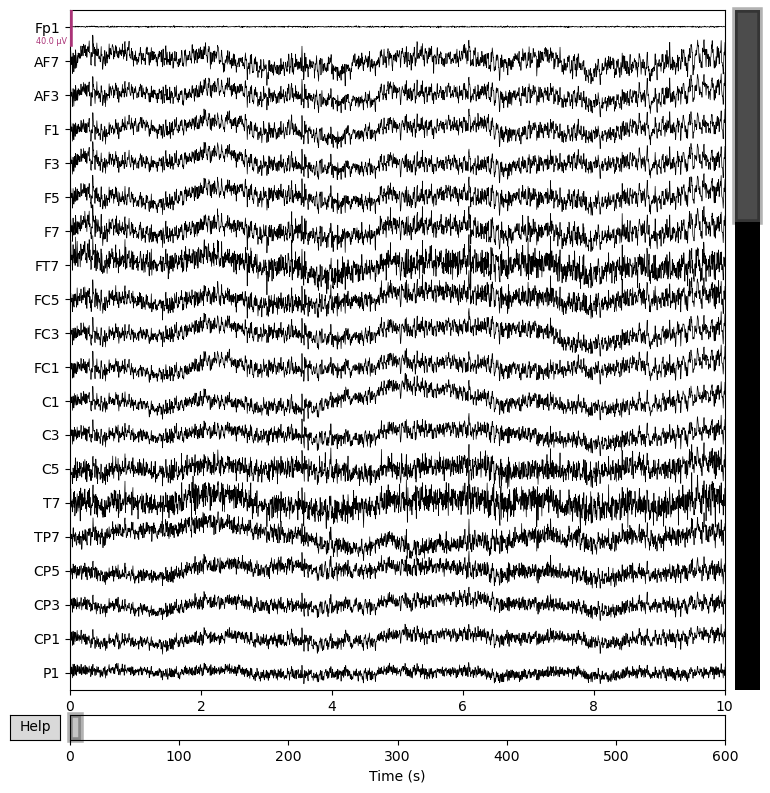

In [11]:
filtered_data[0].plot();

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_2645204/2036467727.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered_data[0].compute_psd().plot(picks="data", exclude="bads", amplitude=False)


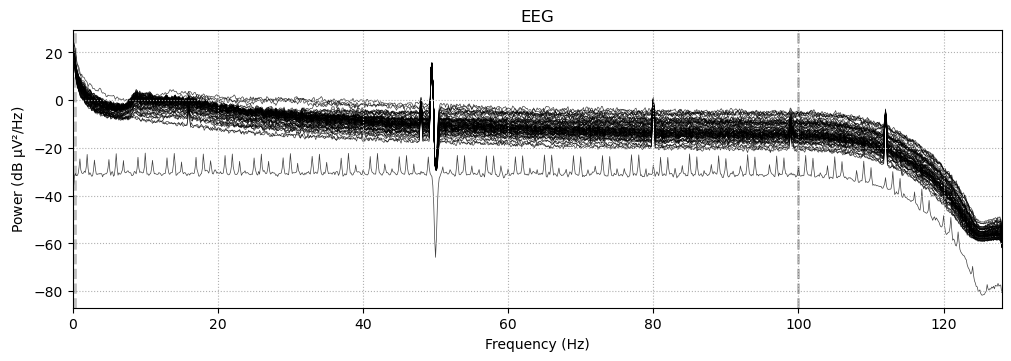

In [12]:
filtered_data[0].compute_psd().plot(picks="data", exclude="bads", amplitude=False)

## Time-Frequency Analysis

In [13]:
from mne.time_frequency import tfr_morlet

### Events trick

As we are not having events in stimulus channels we are defining our own fake events.

In [14]:
# Define artificial events
event_id = dict(whole_data=1)  # Event ID for the artificial events
event_duration = 600  # Duration in seconds

# Create events array
# n_events = int(filtered_data[0].times[-1] // event_duration)
# events = np.zeros((n_events, 3), int)
# events[:, 0] = np.arange(n_events) * event_duration * filtered_data[0].info['sfreq']
# events[:, 2] = event_id
events = np.array([[0, 0, 1]])

In [15]:
# Create epochs
tmin = 0  # Start time before the event
tmax = data.times[-1]  # End time after the event
## Epochs for all 16 sets
epochs_list = [mne.Epochs(data, events, event_id, tmin,tmax, baseline=None, preload=True) for data in filtered_data]

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 153600 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 153600 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 153600 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 153600 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 153600 original time points 

### Applying morlet transformation on each epoch for each data

In [16]:
%%capture

# Define frequencies of interest and number of cycles
frequencies = np.arange(8, 30, 1)  # Example frequencies of interest
n_cycles = frequencies / 5.  # Define number of cycles per frequency

# Compute time-frequency representation
power, itc = [], []
for epochs in epochs_list:
    p, i = mne.time_frequency.tfr_morlet(epochs, freqs=frequencies, n_cycles=n_cycles, use_fft=True,
                                        return_itc=True, decim=3, n_jobs=20, average=True)
    power.append(p)
    itc.append(i)

## Power Spectral Density(PSD)

In [150]:
psdDatas, psdFreqs = [],  []
for i in med1 + med2:
    psdData, psdFreq = filtered_data[i].compute_psd(fmin=2, fmax=110, picks=['Oz']).get_data(return_freqs = True)
    psdDatas.append(psdData)
    psdFreqs.append(psdFreq)

Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Effective window size : 8.000 (s)
Plotting amplitude spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


/tmp/ipykernel_2645204/1844441618.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  filtered_data[0].copy().set_eeg_reference(projection=True).apply_proj().compute_psd(picks=['Oz']).plot(amplitude=True)


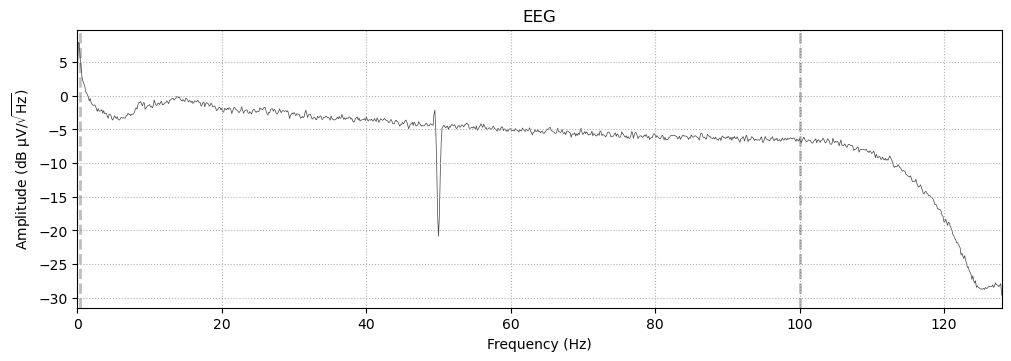

In [129]:
filtered_data[0].copy().set_eeg_reference(projection=True).apply_proj().compute_psd(picks=['Oz']).plot(amplitude=True)

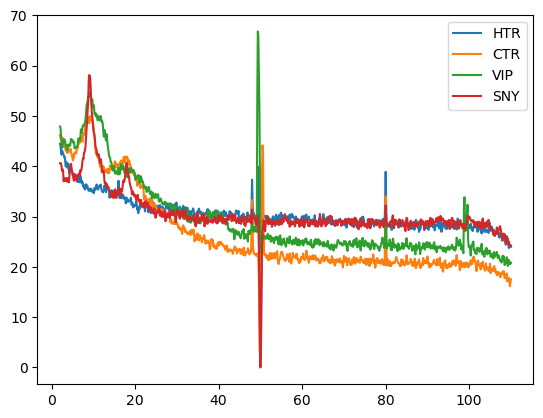

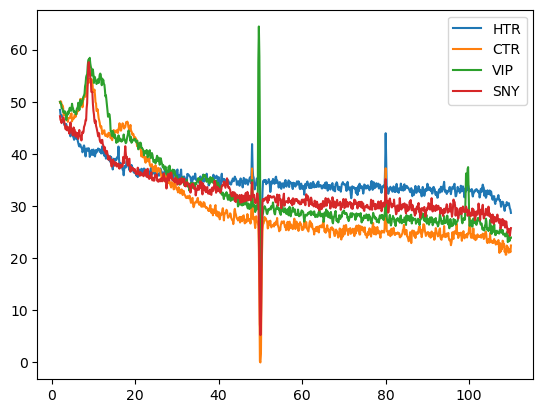

In [163]:
plt.clf()

# Shfit so that positive values
shift_med1 = np.min([np.min(10*np.log10(psdDatas[0][0])), np.min(10*np.log10(psdDatas[1][0])), np.min(10*np.log10(psdDatas[2][0])), np.min(10*np.log10(psdDatas[3][0]))])
# Med1
plt.plot(psdFreq, 10*np.log10(psdDatas[0][0]) - shift_med1);
plt.plot(psdFreq, 10*np.log10(psdDatas[1][0]) - shift_med1);
plt.plot(psdFreq, 10*np.log10(psdDatas[2][0]) - shift_med1);
plt.plot(psdFreq, 10*np.log10(psdDatas[3][0]) - shift_med1);
plt.legend([
    'HTR',
    'CTR',
    'VIP',
    'SNY'
])
plt.show();

plt.clf()

# Shfit so that positive values
shift_med2 = np.min([np.min(10*np.log10(psdDatas[4][0])), np.min(10*np.log10(psdDatas[5][0])), np.min(10*np.log10(psdDatas[6][0])), np.min(10*np.log10(psdDatas[7][0]))])
# Med2
plt.plot(psdFreq, 10*np.log10(psdDatas[4][0]) - shift_med2);
plt.plot(psdFreq, 10*np.log10(psdDatas[5][0]) - shift_med2);
plt.plot(psdFreq, 10*np.log10(psdDatas[6][0]) - shift_med2);
plt.plot(psdFreq, 10*np.log10(psdDatas[7][0]) - shift_med2);
plt.legend([
    'HTR',
    'CTR',
    'VIP',
    'SNY'
])
plt.show();

## Removing pink noise
In this section, we will remove 1/f or pink or fatal noise from our data

In [123]:
def power_law(x, a, b):
    return a * (x ** (-b))

<Figure size 640x480 with 0 Axes>

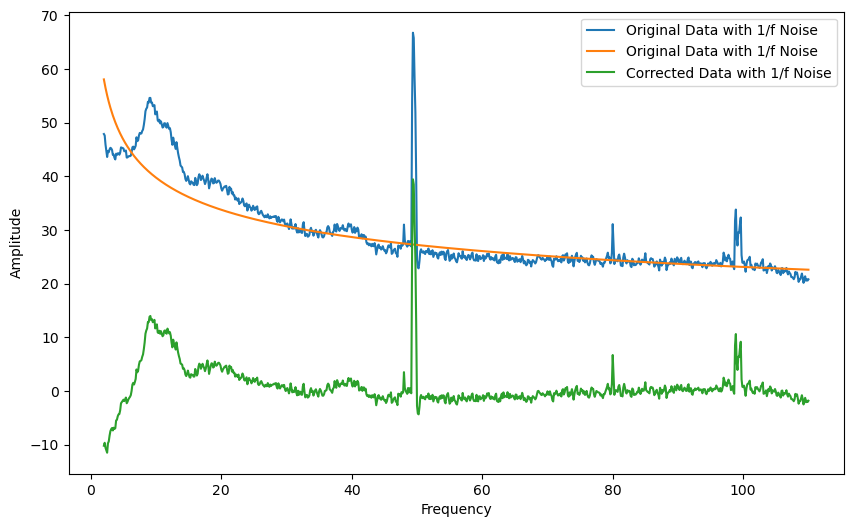

In [166]:
from scipy.optimize import curve_fit

# Select the tail region for fitting
tail_fraction = 0.6
tail_start_index = int((1 - tail_fraction) * len(psdFreqs[0]))

x_tail = psdFreqs[0][tail_start_index:]
y_tail = (10*np.log10(psdDatas[2][0]) - shift_med1)[tail_start_index:]

popt, _ = curve_fit(power_law, x_tail, y_tail)
a, b = popt

y_fit = power_law(psdFreqs[0], a, b)

# # Plot the fitted curve on top of the original data
plt.clf()
plt.figure(figsize=(10, 6))
plt.plot(psdFreq, 10*np.log10(psdDatas[2][0]) - shift_med1, label='Original Data with 1/f Noise');
plt.plot(psdFreq, y_fit, label='Original Data with 1/f Noise');
plt.plot(psdFreq, 10*np.log10(psdDatas[2][0]) - shift_med1 - y_fit, label='Corrected Data with 1/f Noise');
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend()
plt.show();


### Ploting power and itc spectrum

<Figure size 640x480 with 0 Axes>

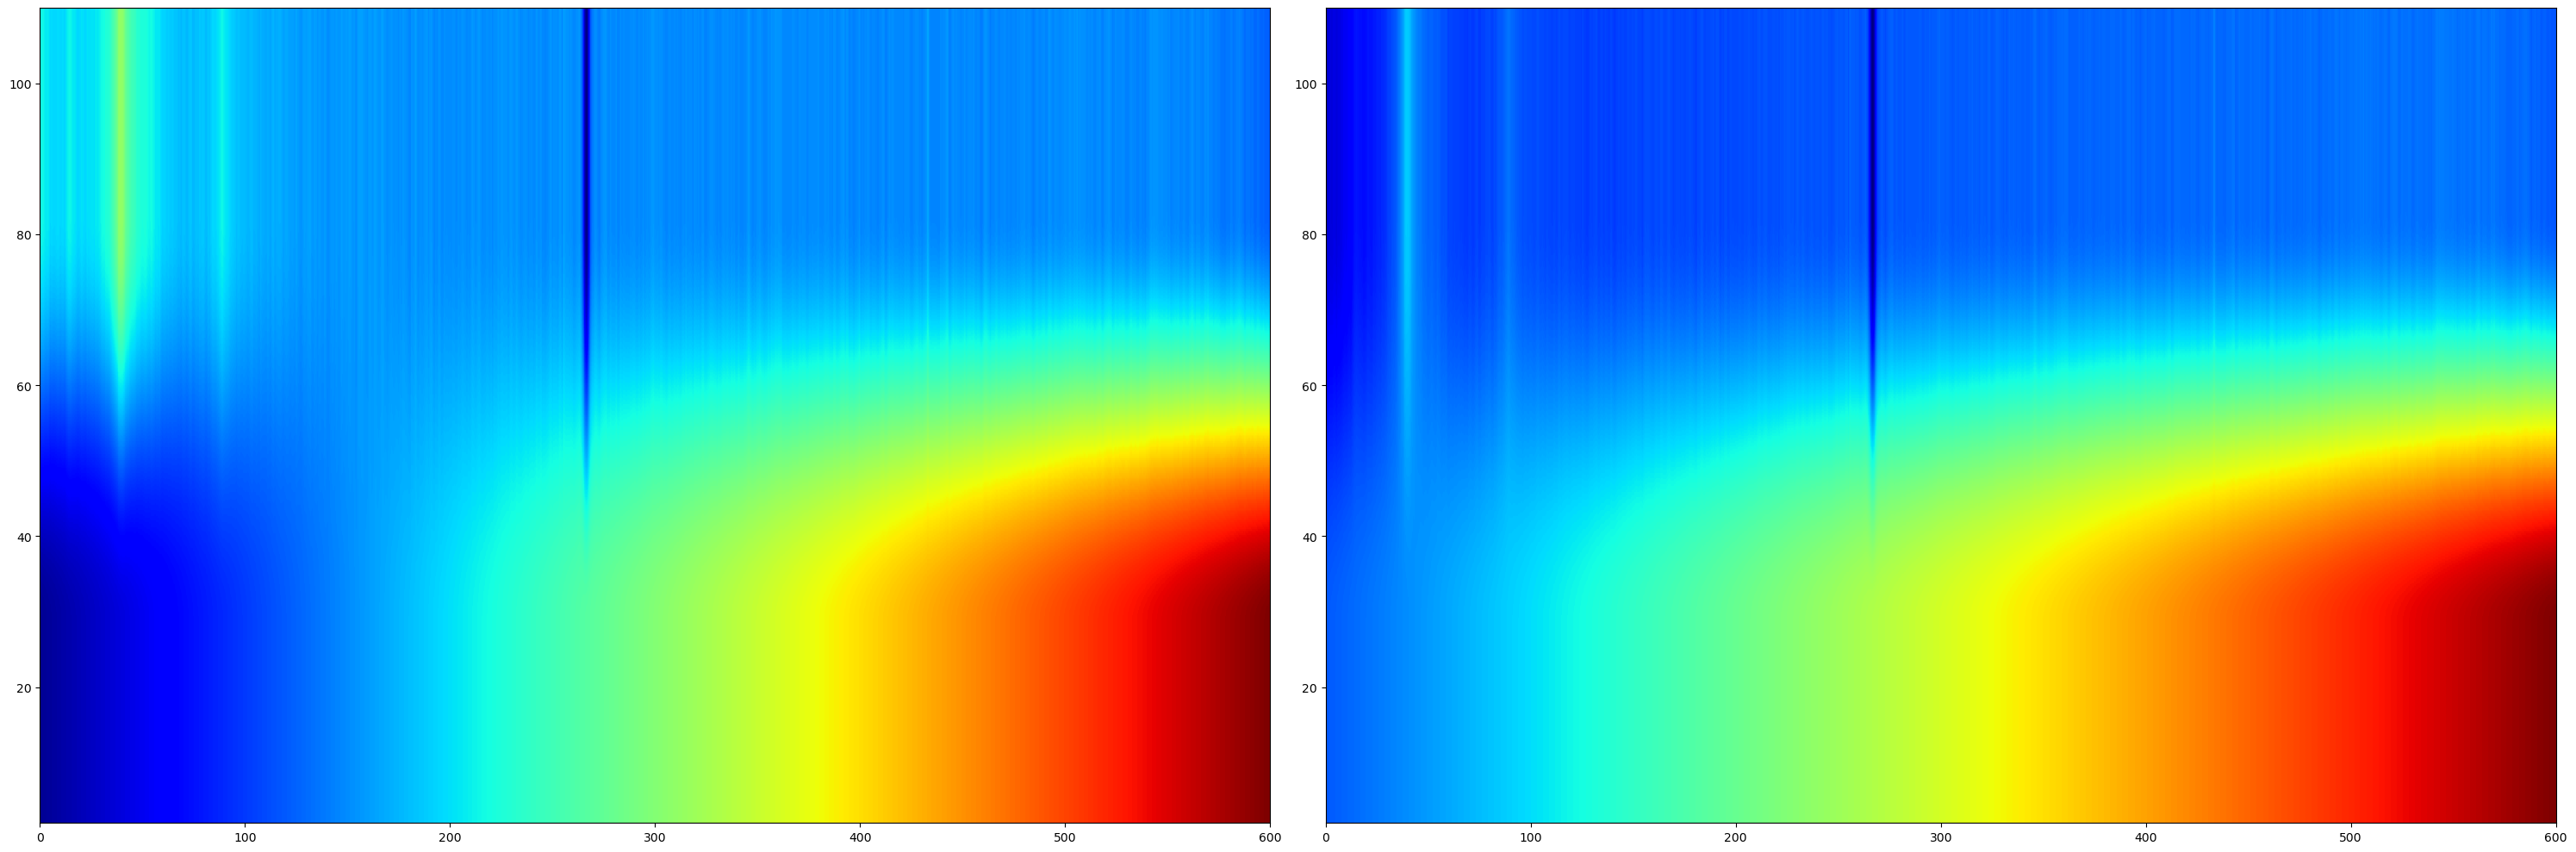

In [171]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10));
im1 = ax1.imshow((psdFreqs[0], (10*np.log10(psdDatas[3][0]) - shift_med1)),origin='lower', aspect='auto', extent=[0, 600, 2, 110], cmap='jet');
im2 = ax2.imshow((psdFreqs[0], 10*np.log10(psdDatas[3][0]) - shift_med1 - y_fit),origin='lower', aspect='auto', extent=[0, 600, 2, 110], cmap='jet');
plt.tight_layout()
plt.show()